<a href="https://colab.research.google.com/github/jorgemm83/prueba_tecnica/blob/main/Prueba_t%C3%A9cnica.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#1. Instalación de bibliotecas necesarias

In [77]:
!pip install requests pandas scikit-learn

#2. Obtención de Datos Financieros
Vamos a usar datos históricos de acciones a través de la API de Alpha Vantage para variables como precios de apertura, cierre, volumen, etc.

In [78]:
import requests
import pandas as pd


def get_financial_data(symbol: str, interval: str):
    #API_KEY = os.getenv('API_KEY')
    API_KEY = 'POK20BXESBQBLR4J'
    URL_API = 'https://www.alphavantage.co/query'

    params = {
        'function': 'TIME_SERIES_INTRADAY',
        'symbol': symbol,
        'interval':interval,
        'outputsize': 'full',
        'apikey': API_KEY,
        'datatype': 'json'
    }


    # Realizar la solicitud GET a la API
    response = requests.get(URL_API, params)

    # Verificar si la solicitud fue exitosa (código 200)
    if response.status_code == 200:
        data = response.json()  # Convertir la respuesta a formato JSON

        #print(data)

         # Comprobar si la respuesta contiene datos válidos
    if "Time Series ("+interval+")" not in data:
        raise ValueError("Error al obtener datos de la API")

    # Convertir los datos a un DataFrame
    df = pd.DataFrame.from_dict(data['Time Series ('+interval+')'], orient='index', dtype=float)

    # Renombrar columnas para que tengan nombres más intuitivos
    df.rename(columns={
        '1. open': 'open',
        '2. high': 'high',
        '3. low': 'low',
        '4. close': 'close',
        '5. volume': 'volume'
    }, inplace=True)

    # Convertir el índice a formato de fecha
    df['date'] = pd.to_datetime(df.index)
    # Procesar los datos
    df = df.sort_values('date')

    return df


# Obtener datos de IBM (IBM)
symbol = 'IBM'
interval='5min'
financial_data = get_financial_data(symbol, interval)

# Mostrar los primeros registros
financial_data.head()

,open,high,low,close,volume,date
2024-08-26 04:00:00,196.20,196.20,196.00,196.00,6.0,2024-08-26 04:00:00
2024-08-26 04:05:00,195.80,196.38,195.68,196.28,176.0,2024-08-26 04:05:00
2024-08-26 04:35:00,195.98,195.98,195.98,195.98,19.0,2024-08-26 04:35:00
2024-08-26 04:40:00,196.28,196.28,196.28,196.28,1.0,2024-08-26 04:40:00
2024-08-26 05:20:00,195.98,195.98,195.98,195.98,1.0,2024-08-26 05:20:00


In [79]:
financial_data.shape

(3199, 6)

In [80]:
data=financial_data

In [81]:
data = data.reset_index(drop=True) #Resets the index and drops the old index
data = data.sort_values('date') #Sorts the values by date
data = data[['date', 'open', 'high', 'low', 'close', 'volume']] #Reorders the columns so 'date' is first
data

,date,open,high,low,close,volume
0,2024-08-26 04:00:00,196.20,196.2000,196.00,196.0000,6.0
1,2024-08-26 04:05:00,195.80,196.3800,195.68,196.2800,176.0
2,2024-08-26 04:35:00,195.98,195.9800,195.98,195.9800,19.0
3,2024-08-26 04:40:00,196.28,196.2800,196.28,196.2800,1.0
4,2024-08-26 05:20:00,195.98,195.9800,195.98,195.9800,1.0
...,...,...,...,...,...,...
3194,2024-09-23 19:25:00,220.40,220.4045,220.40,220.4045,7.0
3195,2024-09-23 19:30:00,220.48,220.4800,220.40,220.4000,14.0
3196,2024-09-23 19:35:00,220.47,220.4900,220.32,220.3200,126.0
3197,2024-09-23 19:45:00,220.40,220.4000,220.25,220.2500,24.0


#2. Dividir datos en conjunto de entrenamiento y prueba
Usa las columnas relevantes como características (X):


In [82]:
X = data[['open', 'high', 'low', 'volume']]
y = data['close']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)


Supongamos que ahora quieres predecir el precio de cierre basándote en las características históricas del precio (apertura, máximo, mínimo, volumen). Utilizaremos regresión lineal para predecir el precio de cierre.

#3. Random Forest con ajuste de hiperparámetros
Utiliza GridSearchCV para ajustar los hiperparámetros:

In [83]:
rf = RandomForestRegressor()

# Definir los parámetros para la búsqueda
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10]
}

grid_search_rf = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', verbose=1)
grid_search_rf.fit(X_train, y_train)

# Mejor modelo
best_rf = grid_search_rf.best_estimator_

# Predicciones
rf_preds = best_rf.predict(X_test)

# Evaluación
rf_rmse = np.sqrt(mean_squared_error(y_test, rf_preds))
print(f'Random Forest RMSE: {rf_rmse}')


Fitting 5 folds for each of 27 candidates, totalling 135 fits
Random Forest RMSE: 1.0794103709877025


#4. XGBoost con ajuste de hiperparámetros
Ajusta el modelo de XGBoost de manera similar:

In [84]:
xgb = XGBRegressor(objective='reg:squarederror')

param_grid_xgb = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.3],
    'max_depth': [3, 5, 7]
}

grid_search_xgb = GridSearchCV(estimator=xgb, param_grid=param_grid_xgb, cv=5, scoring='neg_mean_squared_error', verbose=1)
grid_search_xgb.fit(X_train, y_train)

# Mejor modelo
best_xgb = grid_search_xgb.best_estimator_

# Predicciones
xgb_preds = best_xgb.predict(X_test)

# Evaluación
xgb_rmse = np.sqrt(mean_squared_error(y_test, xgb_preds))
print(f'XGBoost RMSE: {xgb_rmse}')


Fitting 5 folds for each of 27 candidates, totalling 135 fits
XGBoost RMSE: 1.207961123950928


Podemos agregar algunos modelos de regresión adicionales, como Regresión Lineal, Regresión Ridge y Regresión Lasso. A continuación veremos como implementarlos en el contexto de datos multivariados para IBM, junto con el ajuste de hiperparámetros y la validación cruzada.

#7. Importar bibliotecas adicionales

In [85]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import cross_val_score


# 8. Regresión Lineal
Entrenamos y evaluamos el modelo de regresión lineal:

In [86]:
# Regresión Lineal
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

# Predicciones
lin_reg_preds = lin_reg.predict(X_test)

# Evaluación
lin_reg_rmse = np.sqrt(mean_squared_error(y_test, lin_reg_preds))
print(f'Linear Regression RMSE: {lin_reg_rmse}')

# Validación cruzada
lin_reg_cv_scores = cross_val_score(lin_reg, X, y, cv=5, scoring='neg_mean_squared_error')
lin_reg_cv_rmse = np.sqrt(-lin_reg_cv_scores.mean())
print(f'Linear Regression CV RMSE: {lin_reg_cv_rmse}')


Linear Regression RMSE: 0.8088837228804429
Linear Regression CV RMSE: 0.4153270417012365


# 9. Regresión Ridge
Ajusta y evalúa el modelo de regresión Ridge:

In [87]:
# Regresión Ridge
ridge = Ridge()
param_grid_ridge = {
    'alpha': [0.1, 1.0, 10.0, 100.0]
}

grid_search_ridge = GridSearchCV(estimator=ridge, param_grid=param_grid_ridge, cv=5, scoring='neg_mean_squared_error', verbose=1)
grid_search_ridge.fit(X_train, y_train)

# Mejor modelo
best_ridge = grid_search_ridge.best_estimator_

# Predicciones
ridge_preds = best_ridge.predict(X_test)

# Evaluación
ridge_rmse = np.sqrt(mean_squared_error(y_test, ridge_preds))
print(f'Ridge Regression RMSE: {ridge_rmse}')

# Validación cruzada
ridge_cv_scores = cross_val_score(best_ridge, X, y, cv=5, scoring='neg_mean_squared_error')
ridge_cv_rmse = np.sqrt(-ridge_cv_scores.mean())
print(f'Ridge Regression CV RMSE: {ridge_cv_rmse}')


Fitting 5 folds for each of 4 candidates, totalling 20 fits
Ridge Regression RMSE: 0.7700246596503282
Ridge Regression CV RMSE: 0.39967593025363657


# 4. Regresión Lasso
Ajusta y evalúa el modelo de regresión Lasso:

In [88]:
# Regresión Lasso
lasso = Lasso()
param_grid_lasso = {
    'alpha': [0.1, 1.0, 10.0, 100.0]
}

grid_search_lasso = GridSearchCV(estimator=lasso, param_grid=param_grid_lasso, cv=5, scoring='neg_mean_squared_error', verbose=1)
grid_search_lasso.fit(X_train, y_train)

# Mejor modelo
best_lasso = grid_search_lasso.best_estimator_

# Predicciones
lasso_preds = best_lasso.predict(X_test)

# Evaluación
lasso_rmse = np.sqrt(mean_squared_error(y_test, lasso_preds))
print(f'Lasso Regression RMSE: {lasso_rmse}')

# Validación cruzada
lasso_cv_scores = cross_val_score(best_lasso, X, y, cv=5, scoring='neg_mean_squared_error')
lasso_cv_rmse = np.sqrt(-lasso_cv_scores.mean())
print(f'Lasso Regression CV RMSE: {lasso_cv_rmse}')


Fitting 5 folds for each of 4 candidates, totalling 20 fits


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.522e+01, tolerance: 7.129e+00
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.419e+01, tolerance: 8.959e+00
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.633e+01, tolerance: 9.533e

Lasso Regression RMSE: 0.48665228625213935
Lasso Regression CV RMSE: 0.29833992441945717


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.606e+01, tolerance: 1.001e+01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.616e+01, tolerance: 1.561e+01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.610e+01, tolerance: 1.002e

#5. Comparar resultados
Compara el rendimiento de todos los modelos.

In [89]:
# Ordenar el DataFrame por RMSE de menor a mayor
results_df_sorted = results_df.sort_values(by='RMSE')

# Mostrar resultados con un formato más claro
print("Resultados de RMSE de Modelos de Predicción (ordenados de menor a mayor):\n")
for index, row in results_df_sorted.iterrows():
    print(f"{row['Modelo']:<20}: RMSE = {row['RMSE']:.4f}")

Resultados de RMSE de Modelos de Predicción (ordenados de menor a mayor):

Regresión Lasso     : RMSE = 0.4867
Regresión Ridge     : RMSE = 0.7700
Regresión Lineal    : RMSE = 0.8089
Random Forest       : RMSE = 1.0583
XGBoost             : RMSE = 1.2080
LSTM                : RMSE = 206.6436


# 6. Visualizar los resultados de regresión
También puedes visualizar las predicciones de los modelos de regresión junto con los demás modelos:

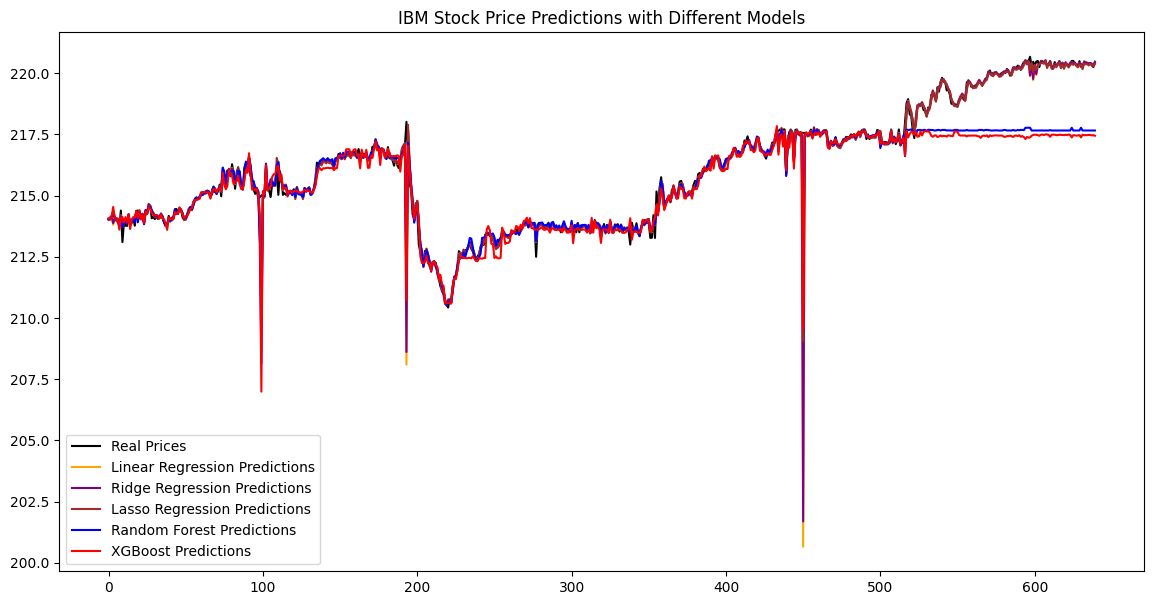

In [90]:
plt.figure(figsize=(14,7))
plt.plot(y_test.reset_index(drop=True), label='Real Prices', color='black')
plt.plot(lin_reg_preds, label='Linear Regression Predictions', color='orange')
plt.plot(ridge_preds, label='Ridge Regression Predictions', color='purple')
plt.plot(lasso_preds, label='Lasso Regression Predictions', color='brown')
plt.plot(rf_preds, label='Random Forest Predictions', color='blue')
plt.plot(xgb_preds, label='XGBoost Predictions', color='red')
plt.legend()
plt.title('IBM Stock Price Predictions with Different Models')
plt.show()
